# Decision Transformer in Atari Pong

Transformer is today's scalable proven architecture, and this architecture is sometimes used for autoregressive sequential modeling (such as, time-series analysis) by leveraging causally masked Transformers.<br>
Decision Transformer is an offline reinforcement learning algorithm also based on autoregressive sequential modeling, which simply outputs the optimal actions by leveraging a causally masked Transformer.

This repository shows you the implementation of Decision Transformer, using introductory **Atari Pong game** environment.

This repository refers the paper and reference implementation of Decision Transformer in [official repository](https://github.com/kzl/decision-transformer), but this notebook shows you the step-by-step instructions for your learning purpose in this repository.<br>
This codebase is also made runnable in the small footprint - such as, in consumer GPUs (NVIDIA RTX) or a signle GPU of Tesla T4.

> Note : Here I assume that you are familiar with Transformer architectures. If you're not familiar with Transformers, please read [this notebook](https://github.com/tsmatz/nlp-tutorials/blob/master/09_transformer.ipynb) before reading and running this example.

In reinforcement learning, the current **state** is given and the agent will then take an appropriate **action** depending on the state. If the action is succeeded, the positive **reward** will be returned to the agent.<br>
In Decision Transformer architecture, the sequence consists of multiple tokens - the desired rewards (so called, **return-to-go rewards**), states, and actions. (See below.) By the autoregressive analysis in transformers, the next token (especially, the next action) will then be predicted (generated) with causal preceeding tokens.

![decision transformer](images/dt.png)

> Note : The **return-to-go rewards (rtgs)** is the sum of future rewards.<br>
> If the sequence is derived by an expert agent, the first token of rtg will then be high score.<br>
> ![Return-to-go reward](images/rtg.png)

Given a dataset of offline trajectories, each tokens (rtgs, states, and actions) will first be embedded into vectors with same dimensions.<br>
The embedded tokens will then be fed into [decoder-only transformer](https://github.com/tsmatz/nlp-tutorials/blob/master/09_transformer.ipynb) (in this example, OpenAI GPT) to generate next tokens.<br>
In the training, only the next actions are used for computing loss and optimization. (The states and rtgs are only used for inputs.)

In this example, we use dataset, which was generated by well-trained DQN (deep Q-network) agent in Google. (See [here](https://research.google/resources/datasets/dqn-replay/).)

> Note : See [here](https://tsmatz.wordpress.com/2021/11/11/reinforcement-learning-visual-attention-in-minecraft/) for the online reinforcement learning with Transformers (which implements GTrXL written in "[Stabilizing Transformers for Reinforcement Learning](https://arxiv.org/abs/1910.06764)").

## Install prerequisite packages

For prerequisites, install the following packages.

In [ ]:
!pip install torch==2.0.0

In [ ]:
!pip install numpy matplotlib opencv-python atari_py

Download and import Roms for Atari environment.

In [ ]:
!sudo apt-get install unrar

In [ ]:
!wget http://www.atarimania.com/roms/Roms.rar

In [ ]:
!unrar x -r Roms.rar

In [ ]:
!python3 -m atari_py.import_roms ROMS

## Atari Pong game environment

First, let's see how you can play Atari Pong games. (In this example, we use ```atari_py``` package.)

Atari Pong is a pong game for two players, in which one paddle is a human player and another is a computer player.

In [1]:
import atari_py

ale = atari_py.ALEInterface()
ale.loadROM(atari_py.get_game_path("pong"))

ale.reset_game()

In this example, the state (visual frame) is gray-scaled and resized image, which size is (84, 84).

In [2]:
import cv2

state = cv2.resize(ale.getScreenGrayscale(), (84, 84), interpolation=cv2.INTER_LINEAR)
state.shape

(84, 84)

<function matplotlib.pyplot.show(close=None, block=None)>

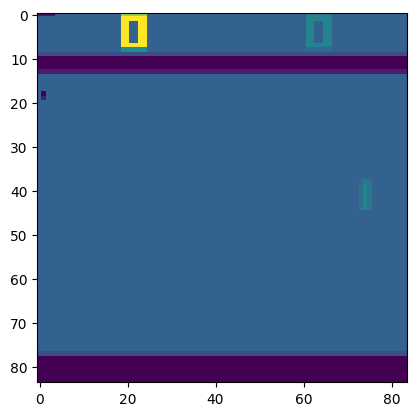

In [3]:
import matplotlib.pyplot as plt

plt.imshow(state) # show last frame
plt.show

You (human player) can take actions (such as, right move, left move, etc) in this game.<br>
The minimal actions in this game are as follows, and we also use only these 6 actions in this example.

| iter # | Act # | Action    |
| ------ | ----  | --------- |
| 0      | 0     | NOOP      |
| 1      | 1     | FIRE      |
| 2      | 3     | RIGHT     |
| 3      | 4     | LEFT      |
| 4      | 11    | RIGHTFIRE |
| 5      | 12    | LEFTFIRE  |

In [4]:
available_actions = ale.getMinimalActionSet()
action_dict = dict([i, e] for i, e in enumerate(available_actions))
action_dict

{0: 0, 1: 1, 2: 3, 3: 4, 4: 11, 5: 12}

In Atari Pong, when you (human player) win the game, you will get 1.0 score. When you lose on contrary, the computer player will get 1.0 score.<br>
An episode will then end up when one player reaches 21.0 scores.

In ```atari-py``` environment, you will receive ```reward=1.0```, when you win the game. And you will receive ```reward=-1.0```, when you lose the game.<br>
The cumulative reward will then be 21.0 in the best playing.

In [5]:
action = 0     # here we always post 0 (NOOP). 
total = 0

while True:
    reward = ale.act(action_dict.get(action))
    if reward > 0.0:
        print(f"You win ({reward})")
    elif reward < 0.0:
        print(f"You lose ({reward})")
    total += reward

    if ale.game_over():
        break

print(f"The episode has ended. (Total {total})")

You lose (-1)
You lose (-1)
You lose (-1)
You lose (-1)
You lose (-1)
You lose (-1)
You lose (-1)
You lose (-1)
You lose (-1)
You lose (-1)
You lose (-1)
You lose (-1)
You lose (-1)
You lose (-1)
You lose (-1)
You lose (-1)
You lose (-1)
You lose (-1)
You lose (-1)
You lose (-1)
You lose (-1)
The episode has ended. (Total -21)


## Download data

Before starting, we need the playing dataset for Atari Pong game.<br>
In this example, we download data from [here](https://research.google/resources/datasets/dqn-replay/), which is generated by well-trained DQN (deep Q-network) agent with 2600 games and 200 million frames.

This data includes not only the best playing and expert's episodes (in which, cumulative reward is near 21.0), but also includes non-expert episodes.

> Note : You can also prepare dataset by your own, by building your own RL agent. (PPO is a widely-used performant RL algorithm today. See [here](https://github.com/tsmatz/reinforcement-learning-tutorials) for details.)

In [7]:
!mkdir downloaded_game_data

In [8]:
!gsutil -m cp -R gs://atari-replay-datasets/dqn/Pong downloaded_game_data

Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_action_ckpt.0.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_action_ckpt.10.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_action_ckpt.12.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_action_ckpt.1.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_action_ckpt.2.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_action_ckpt.11.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_action_ckpt.26.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_action_ckpt.19.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_action_ckpt.14.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_action_ckpt.22.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_action_ckpt.13.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/

Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_observation_ckpt.44.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_observation_ckpt.45.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_observation_ckpt.48.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_observation_ckpt.49.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_observation_ckpt.5.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_observation_ckpt.6.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_observation_ckpt.50.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_observation_ckpt.7.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_observation_ckpt.8.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_observation_ckpt.9.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_reward_ckpt.0.gz...

Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_terminal_ckpt.4.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_terminal_ckpt.5.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_terminal_ckpt.6.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_terminal_ckpt.48.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_terminal_ckpt.49.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_terminal_ckpt.8.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_terminal_ckpt.41.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_terminal_ckpt.7.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_terminal_ckpt.50.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_terminal_ckpt.9.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/$store$_terminal_ckpt.40.gz...
Copying gs://atari-replay-d

Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/invalid_range_ckpt.4.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/invalid_range_ckpt.41.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/invalid_range_ckpt.48.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/invalid_range_ckpt.45.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/invalid_range_ckpt.6.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/invalid_range_ckpt.42.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/invalid_range_ckpt.7.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/invalid_range_ckpt.43.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/invalid_range_ckpt.49.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/invalid_range_ckpt.8.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/invalid_range_ckpt.46.gz...
Copying gs://atari-replay-datasets/dqn/Pong/1/replay_logs/

Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/$store$_observation_ckpt.36.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/$store$_observation_ckpt.37.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/$store$_observation_ckpt.38.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/$store$_observation_ckpt.4.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/$store$_observation_ckpt.39.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/$store$_observation_ckpt.42.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/$store$_observation_ckpt.40.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/$store$_observation_ckpt.43.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/$store$_observation_ckpt.41.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/$store$_observation_ckpt.44.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/$store$_observation_ckp

Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/$store$_terminal_ckpt.32.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/$store$_terminal_ckpt.36.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/$store$_terminal_ckpt.37.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/$store$_terminal_ckpt.38.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/$store$_terminal_ckpt.4.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/$store$_terminal_ckpt.39.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/$store$_terminal_ckpt.42.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/$store$_terminal_ckpt.40.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/$store$_terminal_ckpt.41.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/$store$_terminal_ckpt.43.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/$store$_terminal_ckpt.44.gz...
Copying gs://atari-rep

Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/invalid_range_ckpt.38.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/invalid_range_ckpt.39.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/invalid_range_ckpt.4.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/invalid_range_ckpt.41.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/invalid_range_ckpt.42.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/invalid_range_ckpt.40.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/invalid_range_ckpt.43.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/invalid_range_ckpt.44.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/invalid_range_ckpt.45.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/invalid_range_ckpt.46.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_logs/invalid_range_ckpt.47.gz...
Copying gs://atari-replay-datasets/dqn/Pong/2/replay_lo

Copying gs://atari-replay-datasets/dqn/Pong/3/replay_logs/$store$_terminal_ckpt.29.gz...
Copying gs://atari-replay-datasets/dqn/Pong/3/replay_logs/$store$_terminal_ckpt.27.gz...
Copying gs://atari-replay-datasets/dqn/Pong/3/replay_logs/$store$_terminal_ckpt.28.gz...
Copying gs://atari-replay-datasets/dqn/Pong/3/replay_logs/$store$_terminal_ckpt.3.gz...
Copying gs://atari-replay-datasets/dqn/Pong/3/replay_logs/$store$_terminal_ckpt.31.gz...
Copying gs://atari-replay-datasets/dqn/Pong/3/replay_logs/$store$_terminal_ckpt.30.gz...
Copying gs://atari-replay-datasets/dqn/Pong/3/replay_logs/$store$_terminal_ckpt.35.gz...
Copying gs://atari-replay-datasets/dqn/Pong/3/replay_logs/$store$_terminal_ckpt.36.gz...
Copying gs://atari-replay-datasets/dqn/Pong/3/replay_logs/$store$_terminal_ckpt.37.gz...
Copying gs://atari-replay-datasets/dqn/Pong/3/replay_logs/$store$_terminal_ckpt.38.gz...
Copying gs://atari-replay-datasets/dqn/Pong/3/replay_logs/$store$_terminal_ckpt.32.gz...
Copying gs://atari-rep

Copying gs://atari-replay-datasets/dqn/Pong/3/replay_logs/invalid_range_ckpt.27.gz...
Copying gs://atari-replay-datasets/dqn/Pong/3/replay_logs/invalid_range_ckpt.28.gz...
Copying gs://atari-replay-datasets/dqn/Pong/3/replay_logs/invalid_range_ckpt.29.gz...
Copying gs://atari-replay-datasets/dqn/Pong/3/replay_logs/invalid_range_ckpt.3.gz...
Copying gs://atari-replay-datasets/dqn/Pong/3/replay_logs/invalid_range_ckpt.30.gz...
Copying gs://atari-replay-datasets/dqn/Pong/3/replay_logs/invalid_range_ckpt.31.gz...
Copying gs://atari-replay-datasets/dqn/Pong/3/replay_logs/invalid_range_ckpt.33.gz...
Copying gs://atari-replay-datasets/dqn/Pong/3/replay_logs/invalid_range_ckpt.32.gz...
Copying gs://atari-replay-datasets/dqn/Pong/3/replay_logs/invalid_range_ckpt.34.gz...
Copying gs://atari-replay-datasets/dqn/Pong/3/replay_logs/invalid_range_ckpt.36.gz...
Copying gs://atari-replay-datasets/dqn/Pong/3/replay_logs/invalid_range_ckpt.35.gz...
Copying gs://atari-replay-datasets/dqn/Pong/3/replay_lo

Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/$store$_observation_ckpt.24.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/$store$_observation_ckpt.25.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/$store$_observation_ckpt.26.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/$store$_observation_ckpt.27.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/$store$_observation_ckpt.28.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/$store$_observation_ckpt.29.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/$store$_observation_ckpt.3.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/$store$_observation_ckpt.30.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/$store$_observation_ckpt.32.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/$store$_observation_ckpt.31.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/$store$_observation_ckp

Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/$store$_terminal_ckpt.17.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/$store$_terminal_ckpt.15.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/$store$_terminal_ckpt.22.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/$store$_terminal_ckpt.18.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/$store$_terminal_ckpt.20.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/$store$_terminal_ckpt.19.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/$store$_terminal_ckpt.21.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/$store$_terminal_ckpt.23.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/$store$_terminal_ckpt.24.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/$store$_terminal_ckpt.25.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/$store$_terminal_ckpt.26.gz...
Copying gs://atari-re

Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/invalid_range_ckpt.19.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/invalid_range_ckpt.2.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/invalid_range_ckpt.26.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/invalid_range_ckpt.21.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/invalid_range_ckpt.20.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/invalid_range_ckpt.23.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/invalid_range_ckpt.22.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/invalid_range_ckpt.24.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/invalid_range_ckpt.27.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/invalid_range_ckpt.25.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_logs/invalid_range_ckpt.28.gz...
Copying gs://atari-replay-datasets/dqn/Pong/4/replay_lo

Copying gs://atari-replay-datasets/dqn/Pong/5/replay_logs/$store$_terminal_ckpt.1.gz...
Copying gs://atari-replay-datasets/dqn/Pong/5/replay_logs/$store$_terminal_ckpt.0.gz...
Copying gs://atari-replay-datasets/dqn/Pong/5/replay_logs/$store$_terminal_ckpt.11.gz...
Copying gs://atari-replay-datasets/dqn/Pong/5/replay_logs/$store$_terminal_ckpt.10.gz...
Copying gs://atari-replay-datasets/dqn/Pong/5/replay_logs/$store$_terminal_ckpt.12.gz...
Copying gs://atari-replay-datasets/dqn/Pong/5/replay_logs/$store$_terminal_ckpt.14.gz...
Copying gs://atari-replay-datasets/dqn/Pong/5/replay_logs/$store$_terminal_ckpt.17.gz...
Copying gs://atari-replay-datasets/dqn/Pong/5/replay_logs/$store$_terminal_ckpt.15.gz...
Copying gs://atari-replay-datasets/dqn/Pong/5/replay_logs/$store$_terminal_ckpt.13.gz...
Copying gs://atari-replay-datasets/dqn/Pong/5/replay_logs/$store$_terminal_ckpt.18.gz...
Copying gs://atari-replay-datasets/dqn/Pong/5/replay_logs/$store$_terminal_ckpt.2.gz...
Copying gs://atari-repla

Copying gs://atari-replay-datasets/dqn/Pong/5/replay_logs/add_count_ckpt.8.gz...
Copying gs://atari-replay-datasets/dqn/Pong/5/replay_logs/add_count_ckpt.50.gz...
Copying gs://atari-replay-datasets/dqn/Pong/5/replay_logs/add_count_ckpt.7.gz...
Copying gs://atari-replay-datasets/dqn/Pong/5/replay_logs/invalid_range_ckpt.1.gz...
Copying gs://atari-replay-datasets/dqn/Pong/5/replay_logs/add_count_ckpt.9.gz...
Copying gs://atari-replay-datasets/dqn/Pong/5/replay_logs/invalid_range_ckpt.10.gz...
Copying gs://atari-replay-datasets/dqn/Pong/5/replay_logs/invalid_range_ckpt.0.gz...
Copying gs://atari-replay-datasets/dqn/Pong/5/replay_logs/invalid_range_ckpt.14.gz...
Copying gs://atari-replay-datasets/dqn/Pong/5/replay_logs/invalid_range_ckpt.15.gz...
Copying gs://atari-replay-datasets/dqn/Pong/5/replay_logs/invalid_range_ckpt.13.gz...
Copying gs://atari-replay-datasets/dqn/Pong/5/replay_logs/invalid_range_ckpt.12.gz...
Copying gs://atari-replay-datasets/dqn/Pong/5/replay_logs/invalid_range_ckp

In [9]:
!ls downloaded_game_data/Pong/1/replay_logs

'$store$_action_ckpt.0.gz'	  '$store$_terminal_ckpt.0.gz'
'$store$_action_ckpt.1.gz'	  '$store$_terminal_ckpt.1.gz'
'$store$_action_ckpt.10.gz'	  '$store$_terminal_ckpt.10.gz'
'$store$_action_ckpt.11.gz'	  '$store$_terminal_ckpt.11.gz'
'$store$_action_ckpt.12.gz'	  '$store$_terminal_ckpt.12.gz'
'$store$_action_ckpt.13.gz'	  '$store$_terminal_ckpt.13.gz'
'$store$_action_ckpt.14.gz'	  '$store$_terminal_ckpt.14.gz'
'$store$_action_ckpt.15.gz'	  '$store$_terminal_ckpt.15.gz'
'$store$_action_ckpt.16.gz'	  '$store$_terminal_ckpt.16.gz'
'$store$_action_ckpt.17.gz'	  '$store$_terminal_ckpt.17.gz'
'$store$_action_ckpt.18.gz'	  '$store$_terminal_ckpt.18.gz'
'$store$_action_ckpt.19.gz'	  '$store$_terminal_ckpt.19.gz'
'$store$_action_ckpt.2.gz'	  '$store$_terminal_ckpt.2.gz'
'$store$_action_ckpt.20.gz'	  '$store$_terminal_ckpt.20.gz'
'$store$_action_ckpt.21.gz'	  '$store$_terminal_ckpt.21.gz'
'$store$_action_ckpt.22.gz'	  '$store$_terminal_ckpt.22.gz'
'$store$_action_ckpt.23.gz'	  '$store$_termina

## Prepare (Convert) Data for Dataset

Next we convert data files to which can be used in PyTorch dataset object.

In this example, we create the following data files.

- In this example, we set 50 as the context length. Therefore token's length in a single sequence will then be 150 in Transformers, because it has reward, state, and action in each context.
- We divide all step's data into 50 subsequent steps and save into disk. Each 50 steps includes 50 states, 50 actions, 50 timesteps, and 50 return-to-go (rtg) rewards.
    - states : gray-scaled visual frame information (shape is (84, 84))
    - actions : the taken action # (integer) which range is 0 - 5 (6 different actions)
    - timestep # in a single game (episode) which starts with 0
    - return-to-go (rtg) rewards : see below...
- The state (visual frame) is saved as PNG image with PIL. 50 subsequent states are saved as a single image.
- Other data (actions, rtgs, and timesteps) are converted into numpy array and saved as a pickle. Data is so large, and these data are chunked into 10000 pieces and each part will then be save as a single pickle.

As you can see the below result, 1009180 x 50 steps are saved in the disk.

Unlike regular reinforcement learning, we don't need the discounted rewards. Instead we use the sum of future rewards called **return-to-go (rtg) rewards** as follows. (The model can then predict the action with this expected reward's value.)

![Return-to-go reward](images/rtg.png)

In [10]:
!mkdir game_dataset

In [11]:
import io
import math
import numpy as np

import gzip
import pickle
from PIL import Image
import PIL

source_data_dir = "downloaded_game_data/Pong/1/replay_logs"
dest_dir = "game_dataset"
step_size = 50
chunk_size = 10000  # meta data will be chunked by each 10000 rows
stack_size = 4      # frame stacking size (So stack_size - 1 frames are added in each states)

# initialize
cur_chunk = 0
cur_row = 0
actions_chunk = []
rtgs_chunk = []
timesteps_chunk = []
states_meta_chunk = []

# run loop for the downloaded buffer
for buffer_num in range(50):
    # load data
    acts_file = f"{source_data_dir}/$store$_action_ckpt.{buffer_num}.gz"
    obss_file = f"{source_data_dir}/$store$_observation_ckpt.{buffer_num}.gz"
    rews_file = f"{source_data_dir}/$store$_reward_ckpt.{buffer_num}.gz"
    trms_file = f"{source_data_dir}/$store$_terminal_ckpt.{buffer_num}.gz"
    invs_file = f"{source_data_dir}/invalid_range_ckpt.{buffer_num}.gz"
    with gzip.GzipFile(filename=acts_file) as f:
        acts = np.load(f, allow_pickle=False)
    with gzip.GzipFile(filename=obss_file) as f:
        obss = np.load(f, allow_pickle=False)
    with gzip.GzipFile(filename=rews_file) as f:
        rews = np.load(f, allow_pickle=False)
    with gzip.GzipFile(filename=trms_file) as f:
        trms = np.load(f, allow_pickle=False)
    with gzip.GzipFile(filename=invs_file) as f:
        invalid_idxs = np.load(f, allow_pickle=False)

    # remove invalid indices
    for i in reversed(np.sort(invalid_idxs)):
        acts = np.delete(acts, i)
        obss = np.delete(obss, i, axis=0)
        rews = np.delete(rews, i)
        trms = np.delete(trms, i)

    # record games
    is_first = True
    is_done = True
    for a, o, r, t in zip(acts, obss, rews, trms):
        # initialize array of game data
        if is_done:
            actions = []
            states = []
            rewards = []
            is_done = False
        # save step data in buffer
        actions.append(int(a))
        states.append(o.tolist())
        rewards.append(float(r))
        # when an episode is over, the buffer is saved.
        if t == 1:
            is_done = True
            if is_first:
                # dispose the first game
                # (because it starts in the middle of game ...)
                is_first = False
            else:
                # to numpy
                states = np.array(states, dtype=np.uint8)
                actions = np.array(actions)
                # get step number in this game
                num_steps = len(states)
                # add return-to-go (rtg) rewards
                rtgs = np.zeros(num_steps, dtype=int)
                for i in range(num_steps - 1, -1, -1):
                    cur_and_future_rewards = rewards[i:num_steps]
                    rtgs[i] = sum(cur_and_future_rewards)
                # add timesteps
                timesteps = list(range(num_steps))
                timesteps = np.array(timesteps)
                # reshape (if not fitted, fill with zeros)
                row_num = math.ceil(timesteps.shape[0] / step_size)
                states.resize(row_num, step_size, 84 * 84)
                actions.resize(row_num, step_size)
                rtgs.resize(row_num, step_size)
                timesteps.resize(row_num, step_size)
                # stack_size - 1 frames are added in each states
                append_states = states[:,-(stack_size - 1):,:]                       # (row_num,3,84*84)
                append_states = append_states[:-1,:,:]                               # (row_num-1,3,84*84)
                first_state = np.expand_dims(states[0,0,:], axis=0)                  # (1,84*84)
                first_state = np.repeat(first_state, stack_size - 1, axis=0)         # (3,84*84)
                first_state = np.expand_dims(first_state, axis=0)                    # (1,3,84*84)
                append_states = np.concatenate((first_state, append_states), axis=0) # (row_num,3,84*84)
                states = np.concatenate((append_states, states), axis=1)             # (row_num,step_size+3,84*84)
                # reshaped as image format
                states = states.reshape(row_num, (step_size+stack_size-1) * 84, 84)
                # save
                for i in range(row_num):
                    # save state as image
                    img = Image.fromarray(states[i])
                    im1 = img.save(f"{dest_dir}/{cur_row}.png")
                    # add meta data for states
                    states_meta_chunk.append(cur_row)
                    # save others in chunk (meta data)
                    actions_chunk.append(actions[i])
                    rtgs_chunk.append(rtgs[i])
                    timesteps_chunk.append(timesteps[i])
                    # if row reaches chunk limit, save chunk (as meta data)
                    cur_row += 1
                    if cur_row % chunk_size == 0:
                        with open(f"{dest_dir}/meta{cur_chunk}.pkl","wb") as f:
                            pickle.dump({
                                "actions": np.stack(actions_chunk, axis=0),
                                "rtgs": np.stack(rtgs_chunk, axis=0),
                                "timesteps": np.stack(timesteps_chunk, axis=0),
                                "states_meta": np.stack(states_meta_chunk, axis=0)
                            }, f)
                        cur_chunk += 1
                        actions_chunk = []
                        rtgs_chunk = []
                        timesteps_chunk = []
                        states_meta_chunk = []
                print(f"Processed packs:{buffer_num + 1}/50 rows:{cur_row}", end="\r")

# last (remaining) chunk
if len(actions_chunk) != 0:
    with open(f"{dest_dir}/meta{cur_chunk}.pkl","wb") as f:
        pickle.dump({
            "actions": np.stack(actions_chunk, axis=0),
            "rtgs": np.stack(rtgs_chunk, axis=0),
            "timesteps": np.stack(timesteps_chunk, axis=0),
            "states_meta": np.stack(states_meta_chunk, axis=0),
        }, f)

print("")
print(f"Saved {cur_row} rows in {dest_dir}")

Processed packs:50/50 rows:1009180
Saved 1009180 rows in game_dataset


The original data (the downloaded data) has bias in order, and the latter part tends to have high rtgs (return-to-go rewards).<br>
For this reason, we now shuffle all data.

In [12]:
#
# shuffle all data
#
all_data = None
for chunk_num in range(1000):
    # file check
    if not os.path.exists(f"{dest_dir}/meta{chunk_num}.pkl"):
        break
    # read chunk
    with open(f"{dest_dir}/meta{chunk_num}.pkl", "rb") as f:
        chunk = pickle.load(f)
    # append
    rtgs = chunk["rtgs"]
    states_meta = chunk["states_meta"]
    actions = chunk["actions"]
    timesteps = chunk["timesteps"]
    c = np.c_[
        rtgs.reshape(len(rtgs), -1),
        states_meta.reshape(len(states_meta), -1),
        actions.reshape(len(actions), -1),
        timesteps.reshape(len(timesteps), -1),
    ]
    if all_data is None:
        all_data = c
    else:
        all_data = np.concatenate((all_data, c), axis=0)

# shuffle chunk
np.random.shuffle(all_data)
col = 0
all_rtgs = all_data[:,col:col+step_size].reshape((-1, rtgs.shape[1]))
col += step_size
all_states_meta = all_data[:,col]
col += 1
all_actions = all_data[:,col:col+step_size].reshape((-1, actions.shape[1]))
col += step_size
all_timesteps = all_data[:,col:col+step_size].reshape((-1, timesteps.shape[1]))

# overrite new data
for i, start in enumerate(range(0, len(all_states_meta), chunk_size)):
    with open(f"{dest_dir}/meta{i}.pkl","wb") as f:
        pickle.dump({
            "actions": all_actions[start:start+chunk_size,:],
            "rtgs": all_rtgs[start:start+chunk_size,:],
            "timesteps": all_timesteps[start:start+chunk_size,:],
            "states_meta": all_states_meta[start:start+chunk_size]
        }, f)

Get max timestep value, because this can be used in our model.

In [13]:
import os

max_timesteps = 0
for chunk_num in range(1000):
    # file check
    if not os.path.exists(f"{dest_dir}/meta{chunk_num}.pkl"):
        break
    # read chunk
    with open(f"{dest_dir}/meta{chunk_num}.pkl", "rb") as f:
        chunk = pickle.load(f)
    max_timesteps = max(np.max(chunk["timesteps"]), max_timesteps)

print(max_timesteps)

5409


## Create PyTorch Dataset

Now we create PyTorch dataset for training.

In this example, we inherit ```IterableDataset``` in PyTorch.

In Atari RL, 4 frame stacking (in which 4 histrical frames are stacked) is usually used to infer properties, and here we also apply this stacking. The original 50 step's plain states with shape (50, 84, 84) are then converted into (50, 4, 84, 84)

In [14]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get state array (step_size+stack_size-1) h, w) by file idx
def get_state_from_index(dest_dir, step_size, stack_size, idx):
    img = Image.open(f"{dest_dir}/{idx}.png")
    arr = np.array(img)
    arr = arr.reshape(step_size + stack_size - 1, 84, 84)
    return arr

# array of single frame (batch, step_size+stack_size-1, h, w)
#     to frame stacking (batch, step_size, stack_size, h, w)
def toFrameStack(states, stack_size):
    new_states = states
    new_states = [np.roll(new_states, i, axis=1) for i in reversed(range(stack_size))]
    new_states = np.stack(new_states, axis=2)
    new_states = new_states[:,stack_size - 1:,:,:]
    return new_states

class AtariPongDataset(torch.utils.data.IterableDataset):
    def __init__(self, files_dir, batch_size, step_size, stack_size):
        super(AtariPongDataset).__init__()

        self.files_dir = files_dir
        self.step_size = step_size
        self.batch_size = batch_size
        self.stack_size = stack_size
        
        self.max_chunk = 1000

    def __len__(self):
        length = 0
        for chunk_num in range(self.max_chunk):
            # file check
            if not os.path.exists(f"{self.files_dir}/meta{chunk_num}.pkl"):
                break
            # read chunk
            with open(f"{self.files_dir}/meta{chunk_num}.pkl", "rb") as f:
                chunk = pickle.load(f)
            states_meta = chunk["states_meta"]
            # add batch count
            length += math.ceil(len(states_meta) / self.batch_size)
        return length

    def __iter__(self):
        for chunk_num in range(self.max_chunk):
            # file check
            if not os.path.exists(f"{self.files_dir}/meta{chunk_num}.pkl"):
                break
            # read chunk
            with open(f"{self.files_dir}/meta{chunk_num}.pkl", "rb") as f:
                chunk = pickle.load(f)
            rtgs = chunk["rtgs"]
            states_meta = chunk["states_meta"]
            actions = chunk["actions"]
            timesteps = chunk["timesteps"]
            # shuffle in chunk
            c = np.c_[
                rtgs.reshape(len(rtgs), -1),
                states_meta.reshape(len(states_meta), -1),
                actions.reshape(len(actions), -1),
                timesteps.reshape(len(timesteps), -1),
            ]
            np.random.shuffle(c)
            col = 0
            rtgs = c[:,col:col+self.step_size].reshape(rtgs.shape)
            col += self.step_size
            states_meta = c[:,col]
            col += 1
            actions = c[:,col:col+self.step_size].reshape(actions.shape)
            col += self.step_size
            timesteps = c[:,col:col+self.step_size].reshape(timesteps.shape)
            # process batch
            for i in range(0, len(states_meta), self.batch_size):
                # get rtgs, actions, timesteps
                rtgs_batch = rtgs[i:i+self.batch_size,:]
                actions_batch = actions[i:i+self.batch_size,:]
                timesteps_batch = timesteps[i:i+self.batch_size,:]
                # get states
                states_batch = [get_state_from_index(self.files_dir, self.step_size, self.stack_size, j) for j in states_meta[i:i+self.batch_size]]
                states_batch = np.stack(states_batch, axis=0)
                states_batch = toFrameStack(states_batch, self.stack_size)
                # transform
                rtgs_batch = np.expand_dims(rtgs_batch.astype(float), axis=-1)
                states_batch = states_batch.astype(float) / 255.0
                # yield return
                yield torch.tensor(rtgs_batch, dtype=torch.float32).to(device), torch.tensor(states_batch, dtype=torch.float32).to(device), torch.tensor(actions_batch, dtype=torch.int64).to(device), torch.tensor(timesteps_batch, dtype=torch.int64).to(device)

Let's test our dataset.

As you see, timesteps in our dataset always start by the multiples of 50 (such as, 0, 50, 100, ...).<br>
In this example, **we only train contexts in which timestep always starts by the multiples of 50** in order to speed up training, but you should train other contexts in practice.

In [15]:
# create dataset
dataset = AtariPongDataset(
    files_dir=dest_dir,
    batch_size=3,
    step_size=step_size,
    stack_size=stack_size,
)

# test
for rtgs, states, actions, timesteps in dataset:
    break

print(f"The shape of rtg : {rtgs.size()}")
print(f"The shape of state : {states.size()}")
print(f"The shape of action : {actions.size()}")
print(f"The shape of timestep : {timesteps.size()}")
print("Show timestep :")
print(timesteps)

The shape of rtg : torch.Size([3, 50, 1])
The shape of state : torch.Size([3, 50, 4, 84, 84])
The shape of action : torch.Size([3, 50])
The shape of timestep : torch.Size([3, 50])
Show timestep :
tensor([[2200, 2201, 2202, 2203, 2204, 2205, 2206, 2207, 2208, 2209, 2210, 2211,
         2212, 2213, 2214, 2215, 2216, 2217, 2218, 2219, 2220, 2221, 2222, 2223,
         2224, 2225, 2226, 2227, 2228, 2229, 2230, 2231, 2232, 2233, 2234, 2235,
         2236, 2237, 2238, 2239, 2240, 2241, 2242, 2243, 2244, 2245, 2246, 2247,
         2248, 2249],
        [   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
           12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,   23,
           24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34,   35,
           36,   37,   38,   39,   40,   41,   42,   43,   44,   45,   46,   47,
           48,   49],
        [ 850,  851,  852,  853,  854,  855,  856,  857,  858,  859,  860,  861,
          862,  863,  864,  865

## Build model

Now let's generate Transformer model.

In this notebook, I assume that you're familiar with Transformer.<br>
If you're not familiar, see [here](https://github.com/tsmatz/nlp-tutorials/blob/master/09_transformer.ipynb) for the details about original Transformer.

In the [original paper](https://arxiv.org/abs/2106.01345) of Decision Transformer, **OpenAI GPT** is used for Transformer architecture, and we also use GPT in this example.

GPT is a decoder-only transformer, which is often used for autoregressive modeling. (See [here](https://github.com/tsmatz/nlp-tutorials/blob/master/09_transformer.ipynb) for encoder, decoder, and encoder-decoder in Transformers.)<br>
I note that GPT is different from the original Transformer ("Attention is All You Need") in the following points.

- Positional encoding is not a fixed encoding (not like sinusoidal positional encoding) and it's also learned in the training. (See ```self.global_timestep_encoding``` and ```self.context_position_encoding``` in the following source code.)
- GPT will apply GeLU (Gaussian Error Linear Unit) instead of ReLU for activations.

> Note : As I have mentioned in [here](https://github.com/tsmatz/nlp-tutorials/blob/master/09_transformer.ipynb), OpenAI GPT will also place the layer normalization between the residual blocks, while the original Transformer applies "Add&Norm" in residual layer after applying each operations.<br>
> Compared with original Transformer, masking is simple, because we need only causal self-attention  in decoder-only Transformer. (See ```torch.tril()``` in the following source code.)

First, we use the source code in [karpathy/minGPT](https://github.com/karpathy/minGPT/blob/master/mingpt/model.py) (which is the first version of GPT (GPT-1) described in [this paper](https://s3-us-west-2.amazonaws.com/openai-assets/research-covers/language-unsupervised/language_understanding_paper.pdf)) for the building blocks in OpenAI GPT implementation.

> Note : You can also use ```torch.nn.Transformer``` or ```torch.nn.MultiheadAttention``` when you implement Transformers with PyTorch built-in classes.<br>
> You can also use pre-trained Decision Transformer model in Hugging Face Hub.

In [16]:
"""
The MIT License (MIT) Copyright (c) 2020 Andrej Karpathy
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

https://github.com/karpathy/minGPT/blob/master/LICENSE
"""

import torch
import torch.nn as nn
from torch.nn import functional as F

class NewGELU(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.ModuleDict(dict(
            c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd),
            c_proj  = nn.Linear(4 * config.n_embd, config.n_embd),
            act     = NewGELU(),
            dropout = nn.Dropout(config.resid_pdrop),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.dropout(m.c_proj(m.act(m.c_fc(x)))) # MLP forward

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x

Next we build GPT model for decision sequences as follows.<br>
As I have mentioned above, rtgs, states, and actions are first embedded into vectors with same dimensions, and the embedded tokens will then be fed into GPT to generate next tokens.<br>
In the training, only the next actions are used for computing loss and optimization. (The states and rtgs are only used for inputs in the sequence.)

![Decision Transformer](images/model.png)

In the following code, we build this model (GPT) except embeddings.

The paper of decision transformer says that the positional encoding is based on timesteps, in which each timestep corresponds to three tokens - rtgs, states, and actions. (See the [original paper](https://arxiv.org/abs/2106.01345).)<br>
However, in this example, we'll use {timestep encoding} + {positional encoding in context} as positional encoding, because the length of timestep is large in Atari Pong and then it won't be easy to capture (learn) only timestep encoding.<br>
As we saw above, timestep always starts by the multiples of 50 to make it simplify, and only the multiples of 50 (0, 50, 100, ...) will then be learned in this example.

Same as GPT implementation in [karpathy/minGPT](https://github.com/karpathy/minGPT), we also set the same weight initialization for our GPT model. (See ```_init_weights()``` in the following code.)

In [17]:
class GPT_for_DT(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.block_size = config.block_size
        self.n_embd = config.n_embd

        # build modules
        self.global_timestep_encoding = nn.Embedding(config.max_timestep, config.n_embd)
        self.context_position_encoding = nn.Embedding(config.block_size, config.n_embd)
        self.dropout = nn.Dropout(config.embd_pdrop)
        self.block_loop = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.norm = nn.LayerNorm(config.n_embd)
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # initialize weights
        self.apply(self._init_weights)

    # see karpathy/minGPT for weight's initilization in OpenAI GPT
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    def forward(self, rtgs_emb, states_emb, actions_emb, timesteps):
        # rtgs_emb    : (batch_size, step_size, n_embd)
        # states_emb  : (batch_size, step_size, n_embd)
        # actions_emb : (batch_size, step_size, n_embd)
        # timesteps   : (batch_size, step_size)  <-- but only the first step is used (other steps are ignored)

        batch_size = states_emb.shape[0]
        actual_step_size = states_emb.shape[1]

        #
        # Generate a sequence of tokens :
        # [s], [a], [R] --> [R, s, a, R, s, a, ...]
        #

        token_emb = torch.zeros(
            (batch_size, actual_step_size*3, self.n_embd),
            dtype=torch.float32,
            device=states_emb.device)
        token_emb[:,::3,:] = rtgs_emb
        token_emb[:,1::3,:] = states_emb
        if actions_emb is not None:
            token_emb[:,2::3,:] = actions_emb

        #
        # Position encoding
        #

        timestep_start = torch.repeat_interleave(timesteps[:,0].unsqueeze(dim=-1), actual_step_size*3, dim=-1) # (batch_size, actual_step_size*3)
        pos_global = self.global_timestep_encoding(timestep_start)
        context_position = torch.arange(actual_step_size*3, device=states_emb.device).repeat(batch_size,1) # (batch_size, actual_step_size*3)
        pos_relative = self.context_position_encoding(context_position)
        pos_emb = pos_global + pos_relative

        x = self.dropout(token_emb + pos_emb)

        #
        # Apply multi-layered MHA (multi-head attentions)
        #

        for block in self.block_loop:
            x = block(x)

        x = self.norm(x)

        #
        # Apply Feed-Forward and Return
        #

        logits = self.lm_head(x)
        # only get predictions from states
        logits = logits[:,1::3,:]

        return logits

Next we generate embeddings for each modality (states, actions, and rtgs).

As you saw above, state (visual inputs) is the stacked frame with the shape (4, 84, 84), and the state is then fed into a convolutional encoder instead of a linear layer.

As [paper](https://arxiv.org/abs/2106.01345) says, we use Tanh instead of LayerNorm after embedding each modality.

> Note : As I have mentioned above, we also set the same weight initialization in [karpathy/minGPT](https://github.com/karpathy/minGPT), also in this embeddings.

In [18]:
class Embeddings_for_Atari(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.state_embedding = nn.Sequential(
            nn.Conv2d(4, 32, 8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(3136, config.n_embd),
            nn.Tanh()
        )
        self.action_embedding = nn.Sequential(
            nn.Embedding(config.vocab_size, config.n_embd),
            nn.Tanh()
        )
        self.rtg_embedding = nn.Sequential(
            nn.Linear(1, config.n_embd),
            nn.Tanh()
        )

        # initialize weights
        self.apply(self._init_weights)

    # see karpathy/minGPT for weight's initilization in OpenAI GPT
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    def forward(self, rtgs, states, actions):
        ### inputs
        # rtgs        : (batch_size, step_size, 1)
        # states      : (batch_size, step_size, 4, 84, 84)
        # actions     : (batch_size, step_size)

        ### outputs
        # rtgs_emb    : (batch_size, step_size, n_embd)
        # states_emb  : (batch_size, step_size, n_embd)
        # actions_emb : (batch_size, step_size, n_embd)

        rtgs_emb = self.rtg_embedding(rtgs)
        
        states_shp = states.reshape(-1, 4, 84, 84)
        states_emb = self.state_embedding(states_shp)
        states_emb = states_emb.reshape(states.shape[0], states.shape[1], states_emb.shape[1])

        if actions is None:
            actions_emb = None
        else:
            actions_emb = self.action_embedding(actions)
        
        return rtgs_emb, states_emb, actions_emb

## Load models

Now let's load (instantiate) our models - ```GPT_for_DT``` and ```Embeddings_for_Atari```.

First, we create configuration parameters for preparation.<br>
For the details of these values, see the [original paper](https://arxiv.org/abs/2106.01345). (Here we set the same parameter values in the original paper.)

In [19]:
class CfgNode:
    n_head = 8
    n_layer = 6
    n_embd = 128  # each head has n_embd / n_head
    attn_pdrop = 0.1
    resid_pdrop = 0.1
    embd_pdrop = 0.1
    block_size = step_size * 3
    max_timestep = max_timesteps
    vocab_size = len(action_dict)  # all actions

config = CfgNode()

Now, load model with previous configuration.

In [20]:
gpt = GPT_for_DT(config).to(device)
emb = Embeddings_for_Atari(config).to(device)

## Play game with not-trained agent

Before training, let's play game with not-trained agent.<br>
As you can see below, the agent will easily lose the game, because it's not trained.

> Note : As I have mentioned above, we only train contexts in which timestep always starts by the multiples of 50. For this reason, we always feed the contexts in which timestep always starts by the multiples of 50, also in this agent's test.

In [21]:
import atari_py
from collections import deque
import random

class EnvWrapper():
    def __init__(self, device, stack_size):
        self.device = device
        self.stack_size = stack_size

        self.ale = atari_py.ALEInterface()
        self.ale.setInt("random_seed", 123)
        self.ale.setInt("max_num_frames_per_episode", 108e3)
        self.ale.setFloat("repeat_action_probability", 0)
        self.ale.setInt("frame_skip", 0)
        self.ale.setBool("color_averaging", False)
        self.ale.loadROM(atari_py.get_game_path("pong"))

        actions = self.ale.getMinimalActionSet()
        self.actions = dict([i, e] for i, e in zip(range(len(actions)), actions))

        self.state_buffer = deque([], maxlen=stack_size)

    def _get_state(self):
        state = cv2.resize(self.ale.getScreenGrayscale(), (84, 84), interpolation=cv2.INTER_LINEAR)
        return torch.tensor(state, dtype=torch.float32, device=self.device).div_(255)

    def reset(self):
        for _ in range(self.stack_size):
            self.state_buffer.append(torch.zeros(84, 84, device=self.device))
        self.ale.reset_game()
        # Perform up to 30 random no-ops before starting
        for _ in range(random.randrange(30)):
            self.ale.act(0)  # Assumes raw action 0 is always no-op
            if self.ale.game_over():
                self.ale.reset_game()
        # Process and return "initial" state
        observation = self._get_state()
        self.state_buffer.append(observation)
        return torch.stack(list(self.state_buffer), 0)

    def step(self, action):
        # Repeat action 4 times, max pool over last 2 frames
        frame_buffer = torch.zeros(2, 84, 84, device=self.device)
        reward, done = 0, False
        for t in range(4):
            reward += self.ale.act(self.actions.get(action))
            if t == 2:
                frame_buffer[0] = self._get_state()
            elif t == 3:
                frame_buffer[1] = self._get_state()
            done = self.ale.game_over()
            if done:
                break
        observation = frame_buffer.max(0)[0]
        self.state_buffer.append(observation)
        # Return state, reward, done
        return torch.stack(list(self.state_buffer), 0), reward, done

In [22]:
from torch.nn import functional as F

@torch.no_grad()
def run_game(target_rtg, emb, gpt, device, stack_size, max_timesteps):
    #model.train(False)

    env = EnvWrapper(device, stack_size)

    done = True

    # reset
    state = env.reset()
    state = state.type(torch.float32).to(device).unsqueeze(0)
    rtgs = [target_rtg]

    # pick up next action
    rtgs_emb, states_emb, actions_emb = emb(
        rtgs=torch.tensor(rtgs, dtype=torch.long).to(device).unsqueeze(0).unsqueeze(-1).type(torch.float32),
        states=state.unsqueeze(0),
        actions=None,
    )
    logits = gpt(
        rtgs_emb=rtgs_emb,
        states_emb=states_emb,
        actions_emb=actions_emb,
        timesteps=torch.zeros((1, 1), dtype=torch.int64).to(device),
    )
    logits = logits[:, -1, :]
    probs = F.softmax(logits, dim=-1)
    sampled_action = torch.multinomial(probs, num_samples=1)

    time_start = 0
    all_states = state
    actions = []
    reward_sum = 0
    while True:
        action = sampled_action.cpu().numpy()[0,-1]
        actions += [sampled_action]
        state, reward, done = env.step(action)
        reward_sum += reward
        if reward > 0:
            print(f"You won {reward}")
        elif reward < 0:
            print(f"You lose {reward}")

        if done:
            print(f"The game has finished - total reward {reward_sum}")
            break

        state = state.unsqueeze(0).to(device)
        all_states = torch.cat([all_states, state], dim=0)

        rtgs += [rtgs[-1] - reward]

        # get last step_size size in sequence
        for t in range(time_start, len(all_states), step_size):
            batch_states = all_states.unsqueeze(0)[:, t:t+step_size]
            batch_actions = torch.tensor(actions+[0], dtype=torch.long).to(device).unsqueeze(0)[:, t:t+step_size]
            batch_rtgs = torch.tensor(rtgs, dtype=torch.long).to(device).unsqueeze(0).unsqueeze(-1)[:, t:t+step_size].type(torch.float32)
        time_start = t

        # pick up next action
        rtgs_emb, states_emb, actions_emb = emb(
            rtgs=batch_rtgs,
            states=batch_states,
            actions=batch_actions,
        )
        logits = gpt(
            rtgs_emb=rtgs_emb,
            states_emb=states_emb,
            actions_emb=actions_emb,
            #####timesteps=(min(t, max_timesteps) * torch.ones((1, 1), dtype=torch.int64).to(device)),
            timesteps=torch.arange(min(t, max_timesteps), min(t, max_timesteps) + len(states_emb)).unsqueeze(0).to(device),
        )
        logits = logits[:, -1, :]
        probs = F.softmax(logits, dim=-1)
        sampled_action = torch.multinomial(probs, num_samples=1)

In [23]:
run_game(20.0, emb, gpt, device, stack_size, max_timesteps)

/tmp/ipykernel_1857/4256280854.py:19: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  rtgs=torch.tensor(rtgs, dtype=torch.long).to(device).unsqueeze(0).unsqueeze(-1).type(torch.float32),
/tmp/ipykernel_1857/4256280854.py:60: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  batch_rtgs = torch.tensor(rtgs, dtype=torch.long).to(device).unsqueeze(0).unsqueeze(-1)[:, t:t+step_size].type(torch.float32)


You lose -1
You lose -1
You lose -1
You lose -1
You lose -1
You lose -1
You lose -1
You lose -1
You lose -1
You lose -1
You lose -1
You lose -1
You lose -1
You lose -1
You lose -1
You lose -1
You lose -1
You lose -1
You lose -1
You lose -1
You lose -1
The game has finished - total reward -21


## Train model

Now let's train the model.

Before training, we configure the PyTorch optimizer same as the implementation in [karpathy/minGPT](https://github.com/karpathy/minGPT).<br>
In this optimizer, we separates all weights into decay and no-decay corresponding to the type of module.

In [24]:
"""
The MIT License (MIT) Copyright (c) 2020 Andrej Karpathy
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

https://github.com/karpathy/minGPT/blob/master/LICENSE
"""

def configure_optimizers(gpt, emb, weight_decay=0.1, learning_rate=6e-4, betas=(0.9, 0.95)):
    """
    This long function is unfortunately doing something very simple and is being very defensive:
    We are separating out all parameters of the model into two buckets: those that will experience
    weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
    We are then returning the PyTorch optimizer object.
    """

    # separate out all parameters to those that will and won't experience regularizing weight decay
    decay = set()
    no_decay = set()
    whitelist_weight_modules = (torch.nn.Linear, torch.nn.Conv2d)
    blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
    for mn, m in gpt.named_modules():
        for pn, p in m.named_parameters():
            fpn = '%s.%s' % (mn, pn) if mn else pn # full param name
            # random note: because named_modules and named_parameters are recursive
            # we will see the same tensors p many many times. but doing it this way
            # allows us to know which parent module any tensor p belongs to...
            if pn.endswith('bias'):
                # all biases will not be decayed
                no_decay.add(fpn)
            elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                # weights of whitelist modules will be weight decayed
                decay.add(fpn)
            elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                # weights of blacklist modules will NOT be weight decayed
                no_decay.add(fpn)
    for mn, m in emb.named_modules():
        for pn, p in m.named_parameters():
            fpn = '%s.%s' % (mn, pn) if mn else pn # full param name
            # random note: because named_modules and named_parameters are recursive
            # we will see the same tensors p many many times. but doing it this way
            # allows us to know which parent module any tensor p belongs to...
            if pn.endswith('bias'):
                # all biases will not be decayed
                no_decay.add(fpn)
            elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                # weights of whitelist modules will be weight decayed
                decay.add(fpn)
            elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                # weights of blacklist modules will NOT be weight decayed
                no_decay.add(fpn)

    # validate that we considered every parameter
    gpt_param_dict = {pn: p for pn, p in gpt.named_parameters()}
    emb_param_dict = {pn: p for pn, p in emb.named_parameters()}
    param_dict = {**gpt_param_dict, **emb_param_dict}
    inter_params = decay & no_decay
    union_params = decay | no_decay
    assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
    assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                % (str(param_dict.keys() - union_params), )

    # create the pytorch optimizer object
    optim_groups = [
        {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": weight_decay},
        {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
    ]
    optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas)
    return optimizer

optimizer = configure_optimizers(gpt, emb)

Now let's start training with the previous optimizer.

When the episode ends in the middle of sequence, timestep's value will also become zero in the middle of sequence. And, in this case, the subsequent tokens should be ignored.<br>
To do this in the training, we set -100 as label id in such tokens, because PyTorch cross-entropy function (```torch.nn.functional.cross_entropy()```) has a property ```ignore_index``` which default value is -100.

As mentioned in [the paper](https://arxiv.org/abs/2106.01345), we also apply learning rate scheduler by cosine annealing. (See [here](https://paperswithcode.com/method/cosine-annealing) for cosine annealing learning rate.)

> Note : In the original paper, batch size is 512, but here we set 128 to make runnable in small footprint.

In [25]:
batch_size = 128
epochs = 5

# load dataset
dataset = AtariPongDataset(
    files_dir=dest_dir,
    batch_size=batch_size,
    step_size=step_size,
    stack_size=stack_size,
)

# get total number of batch
total_batch = len(dataset)

# set cosine annealing cycle
lr_tokens_cycle = total_batch * batch_size * step_size // 20
processed_tokens = 0

# run training loop
for epoch_num in range(epochs):
    for i, (rtgs, states, actions, timesteps) in enumerate(dataset):
        # create label (see above note)
        mask = (timesteps[:,1:]==0).int()
        mask = torch.cat((torch.zeros((mask.shape[0], 1), dtype=torch.int64).to(device), mask), dim=1)
        mask = torch.cumsum(mask, dim=1)
        labels = actions.masked_fill(mask != 0, -100)
        # process step
        optimizer.zero_grad()
        rtgs_emb, states_emb, actions_emb = emb(rtgs, states, actions)
        logits = gpt(rtgs_emb, states_emb, actions_emb, timesteps)
        loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), labels.reshape(-1))
        loss.backward()
        optimizer.step()
        # print loss
        print(f"epoch {epoch_num+1} iter {i + 1}/{total_batch} - loss: {loss.item() :2.4f}", end="\r")
        # schedule learning rate (see above)
        processed_tokens += (labels >= 0).sum()
        lr_mult = max(0.1, 0.5 * (1.0 + math.cos(math.pi * float(processed_tokens) / float(lr_tokens_cycle))))
        lr = 6e-4 * lr_mult
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr
    print("")

print("done")

epoch 1 iter 7972/7972 - loss: 1.4473
epoch 2 iter 7972/7972 - loss: 1.3923
epoch 3 iter 7972/7972 - loss: 1.3649
epoch 4 iter 7972/7972 - loss: 1.3703
epoch 5 iter 7972/7972 - loss: 1.3340
done


[Optional] If you save checkpoint in file, run as follows.

In [ ]:
# save model
torch.save(emb.state_dict(), "model_embedding")
torch.save(gpt.state_dict(), "model_gpt")

[Option] If you load model from file, run as follows.

In [ ]:
# load model
emb = Embeddings_for_Atari(config).to(device)
gpt = GPT_for_DT(config).to(device)
emb.load_state_dict(torch.load("model_embedding"))
emb.eval()
gpt.load_state_dict(torch.load("model_gpt"))
gpt.eval()

## Play game with the trained agent

After the training has completed, let's play game with the well-trained agent !

In [26]:
run_game(20.0, emb, gpt, device, stack_size, max_timesteps)

/tmp/ipykernel_2346/4256280854.py:19: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  rtgs=torch.tensor(rtgs, dtype=torch.long).to(device).unsqueeze(0).unsqueeze(-1).type(torch.float32),
/tmp/ipykernel_2346/4256280854.py:60: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  batch_rtgs = torch.tensor(rtgs, dtype=torch.long).to(device).unsqueeze(0).unsqueeze(-1)[:, t:t+step_size].type(torch.float32)


You won 1
You won 1
You won 1
You won 1
You won 1
You won 1
You won 1
You won 1
You won 1
You won 1
You won 1
You won 1
You won 1
You won 1
You won 1
You won 1
You won 1
You won 1
You lose -1
You won 1
You won 1
You won 1
The game has finished - total reward 20
